In [ ]:
!pip -q install kaggle

In [ ]:
import tensorflow as tf
import os
import json
import pandas as pd
import re
import numpy as np
import time
import matplotlib.pyplot as plt
import collections
import random
import requests
from math import sqrt
from PIL import Image
from tqdm.auto import tqdm

In [ ]:
if not os.path.exists('/content/data/'):

    api_token = {"username": "akhila234",
                 "key": "45898da342cb4a5a669c656802c91300"}

    with open('/content/kaggle.json', 'w') as file:
        json.dump(api_token, file)

    os.environ["KAGGLE_CONFIG_DIR"] = "/content/"

    os.system('kaggle datasets download -d adityajn105/flickr8k')
    os.makedirs('/content/data/', exist_ok=True)
    os.system('mv /content/flickr8k.zip /content/data/flickr8k.zip')
    os.system('unzip -q /content/data/flickr8k.zip -d /content/data/')
    os.remove('/content/data/flickr8k.zip')

In [ ]:
captions = pd.read_csv('/content/data/captions.txt')
captions['image'] = captions['image'].apply(
    lambda x: f'/content/data/Images/{x}')
captions.head()

image  \
0  /content/data/Images/1000268201_693b08cb0e.jpg   
1  /content/data/Images/1000268201_693b08cb0e.jpg   
2  /content/data/Images/1000268201_693b08cb0e.jpg   
3  /content/data/Images/1000268201_693b08cb0e.jpg   
4  /content/data/Images/1000268201_693b08cb0e.jpg   

                                             caption  
0  A child in a pink dress is climbing up a set o...  
1              A girl going into a wooden building .  
2   A little girl climbing into a wooden playhouse .  
3  A little girl climbing the stairs to her playh...  
4  A little girl in a pink dress going into a woo...

In [ ]:
def preprocess(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub('\s+', ' ', text)
    text = text.strip()
    text = '[start] ' + text + ' [end]'
    return text

<>:4: SyntaxWarning: invalid escape sequence '\s'
<>:4: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipython-input-3433793754.py:4: SyntaxWarning: invalid escape sequence '\s'
  text = re.sub('\s+', ' ', text)


In [ ]:
captions['caption'] = captions['caption'].apply(preprocess)
captions.head()

image  \
0  /content/data/Images/1000268201_693b08cb0e.jpg   
1  /content/data/Images/1000268201_693b08cb0e.jpg   
2  /content/data/Images/1000268201_693b08cb0e.jpg   
3  /content/data/Images/1000268201_693b08cb0e.jpg   
4  /content/data/Images/1000268201_693b08cb0e.jpg   

                                             caption  
0  [start] a child in a pink dress is climbing up...  
1  [start] a girl going into a wooden building [end]  
2  [start] a little girl climbing into a wooden p...  
3  [start] a little girl climbing the stairs to h...  
4  [start] a little girl in a pink dress going in...

[start] two dogs try to get the chewedup red frisbee from the other [end]



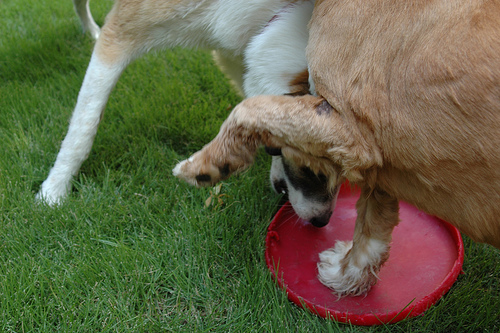

In [ ]:
random_row = captions.sample(1).iloc[0]
print(random_row.caption)
print()
im = Image.open(random_row.image)
im

In [ ]:
MAX_LENGTH = 40
VOCABULARY_SIZE = 10000
BATCH_SIZE = 32
BUFFER_SIZE = 1000
EMBEDDING_DIM = 512
UNITS = 512

In [ ]:
tokenizer = tf.keras.layers.TextVectorization(
    max_tokens=VOCABULARY_SIZE,
    standardize=None,
    output_sequence_length=MAX_LENGTH)

tokenizer.adapt(captions['caption'])

In [ ]:
word2idx = tf.keras.layers.StringLookup(
    mask_token="",
    vocabulary=tokenizer.get_vocabulary())

idx2word = tf.keras.layers.StringLookup(
    mask_token="",
    vocabulary=tokenizer.get_vocabulary(),
    invert=True)

In [ ]:
img_to_cap_vector = collections.defaultdict(list)
for img, cap in zip(captions['image'], captions['caption']):
    img_to_cap_vector[img].append(cap)

img_keys = list(img_to_cap_vector.keys())
random.shuffle(img_keys)

slice_index = int(len(img_keys)*0.8)
img_name_train_keys, img_name_val_keys = (img_keys[:slice_index],
                                          img_keys[slice_index:])

train_imgs = []
train_captions = []
for imgt in img_name_train_keys:
    capt_len = len(img_to_cap_vector[imgt])
    train_imgs.extend([imgt] * capt_len)
    train_captions.extend(img_to_cap_vector[imgt])

val_imgs = []
val_captions = []
for imgv in img_name_val_keys:
    capv_len = len(img_to_cap_vector[imgv])
    val_imgs.extend([imgv] * capv_len)
    val_captions.extend(img_to_cap_vector[imgv])

In [ ]:
len(train_imgs), len(train_captions), len(val_imgs), len(val_captions)

(32360, 32360, 8095, 8095)

In [ ]:
def load_data(img_path, caption):
    img = tf.io.read_file(img_path)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.keras.layers.Resizing(299, 299)(img)
    img = img / 255.
    caption = tokenizer(caption)
    return img, caption

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices(
    (train_imgs, train_captions))

train_dataset = train_dataset.map(
    load_data, num_parallel_calls=tf.data.AUTOTUNE
    ).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

val_dataset = tf.data.Dataset.from_tensor_slices(
    (val_imgs, val_captions))

val_dataset = val_dataset.map(
    load_data, num_parallel_calls=tf.data.AUTOTUNE
    ).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [ ]:
image_augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.RandomFlip("horizontal"),
        tf.keras.layers.RandomRotation(0.2),
        tf.keras.layers.RandomContrast(0.3),
    ]
)

In [ ]:
def CNN_Encoder():
    inception_v3 = tf.keras.applications.InceptionV3(
        include_top=False,
        weights='imagenet'
    )
    inception_v3.trainable = False

    output = inception_v3.output
    output = tf.keras.layers.Reshape(
        (-1, output.shape[-1]))(output)

    cnn_model = tf.keras.models.Model(inception_v3.input, output)
    return cnn_model

In [ ]:
class TransformerEncoderLayer(tf.keras.layers.Layer):

    def __init__(self, embed_dim, num_heads):
        super().__init__()
        self.layer_norm_1 = tf.keras.layers.LayerNormalization()
        self.layer_norm_2 = tf.keras.layers.LayerNormalization()
        self.attention = tf.keras.layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim)
        self.dense = tf.keras.layers.Dense(embed_dim, activation="relu")


    def call(self, x, training):
        x = self.layer_norm_1(x)
        x = self.dense(x)

        attn_output = self.attention(
            query=x,
            value=x,
            key=x,
            attention_mask=None,
            training=training
        )

        x = self.layer_norm_2(x + attn_output)
        return x

In [ ]:
class Embeddings(tf.keras.layers.Layer):

    def __init__(self, vocab_size, embed_dim, max_len):
        super().__init__()
        self.token_embeddings = tf.keras.layers.Embedding(
            vocab_size, embed_dim)
        self.position_embeddings = tf.keras.layers.Embedding(
            max_len, embed_dim, input_shape=(None, max_len))


    def call(self, input_ids):
        length = tf.shape(input_ids)[-1]
        position_ids = tf.range(start=0, limit=length, delta=1)
        position_ids = tf.expand_dims(position_ids, axis=0)

        token_embeddings = self.token_embeddings(input_ids)
        position_embeddings = self.position_embeddings(position_ids)

        return token_embeddings + position_embeddings

In [ ]:
Embeddings(tokenizer.vocabulary_size(), EMBEDDING_DIM, MAX_LENGTH)(next(iter(train_dataset))[1]).shape

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:100: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


TensorShape([32, 40, 512])

In [ ]:
class TransformerDecoderLayer(tf.keras.layers.Layer):

    def __init__(self, embed_dim, units, num_heads):
        super().__init__()
        self.embedding = Embeddings(
            tokenizer.vocabulary_size(), embed_dim, MAX_LENGTH)

        self.attention_1 = tf.keras.layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim, dropout=0.1
        )
        self.attention_2 = tf.keras.layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim, dropout=0.1
        )

        self.layernorm_1 = tf.keras.layers.LayerNormalization()
        self.layernorm_2 = tf.keras.layers.LayerNormalization()
        self.layernorm_3 = tf.keras.layers.LayerNormalization()

        self.ffn_layer_1 = tf.keras.layers.Dense(units, activation="relu")
        self.ffn_layer_2 = tf.keras.layers.Dense(embed_dim)

        self.out = tf.keras.layers.Dense(tokenizer.vocabulary_size(), activation="softmax")

        self.dropout_1 = tf.keras.layers.Dropout(0.3)
        self.dropout_2 = tf.keras.layers.Dropout(0.5)


    def call(self, input_ids, encoder_output, training, mask=None):
        embeddings = self.embedding(input_ids)

        combined_mask = None
        padding_mask = None

        if mask is not None:
            causal_mask = self.get_causal_attention_mask(embeddings)
            padding_mask = tf.cast(mask[:, :, tf.newaxis], dtype=tf.int32)
            combined_mask = tf.cast(mask[:, tf.newaxis, :], dtype=tf.int32)
            combined_mask = tf.minimum(combined_mask, causal_mask)

        attn_output_1 = self.attention_1(
            query=embeddings,
            value=embeddings,
            key=embeddings,
            attention_mask=combined_mask,
            training=training
        )

        out_1 = self.layernorm_1(embeddings + attn_output_1)

        attn_output_2 = self.attention_2(
            query=out_1,
            value=encoder_output,
            key=encoder_output,
            attention_mask=padding_mask,
            training=training
        )

        out_2 = self.layernorm_2(out_1 + attn_output_2)

        ffn_out = self.ffn_layer_1(out_2)
        ffn_out = self.dropout_1(ffn_out, training=training)
        ffn_out = self.ffn_layer_2(ffn_out)

        ffn_out = self.layernorm_3(ffn_out + out_2)
        ffn_out = self.dropout_2(ffn_out, training=training)
        preds = self.out(ffn_out)
        return preds


    def get_causal_attention_mask(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        i = tf.range(sequence_length)[:, tf.newaxis]
        j = tf.range(sequence_length)
        mask = tf.cast(i >= j, dtype="int32")
        mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))
        mult = tf.concat(
            [tf.expand_dims(batch_size, -1), tf.constant([1, 1], dtype=tf.int32)],
            axis=0
        )
        return tf.tile(mask, mult)

In [ ]:
class ImageCaptioningModel(tf.keras.Model):

    def __init__(self, cnn_model, encoder, decoder, image_aug=None):
        super().__init__()
        self.cnn_model = cnn_model
        self.encoder = encoder
        self.decoder = decoder
        self.image_aug = image_aug
        self.loss_tracker = tf.keras.metrics.Mean(name="loss")
        self.acc_tracker = tf.keras.metrics.Mean(name="accuracy")


    def calculate_loss(self, y_true, y_pred, mask):
        loss = self.loss(y_true, y_pred)
        mask = tf.cast(mask, dtype=loss.dtype)
        loss *= mask
        return tf.reduce_sum(loss) / tf.reduce_sum(mask)


    def calculate_accuracy(self, y_true, y_pred, mask):
        accuracy = tf.equal(y_true, tf.argmax(y_pred, axis=2))
        accuracy = tf.math.logical_and(mask, accuracy)
        accuracy = tf.cast(accuracy, dtype=tf.float32)
        mask = tf.cast(mask, dtype=tf.float32)
        return tf.reduce_sum(accuracy) / tf.reduce_sum(mask)


    def compute_loss_and_acc(self, img_embed, captions, training=True):
        encoder_output = self.encoder(img_embed, training=True)
        y_input = captions[:, :-1]
        y_true = captions[:, 1:]
        mask = (y_true != 0)
        y_pred = self.decoder(
            y_input, encoder_output, training=True, mask=mask
        )
        loss = self.calculate_loss(y_true, y_pred, mask)
        acc = self.calculate_accuracy(y_true, y_pred, mask)
        return loss, acc


    def train_step(self, batch):
        imgs, captions = batch

        if self.image_aug:
            imgs = self.image_aug(imgs)

        img_embed = self.cnn_model(imgs)

        with tf.GradientTape() as tape:
            loss, acc = self.compute_loss_and_acc(
                img_embed, captions
            )

        train_vars = (
            self.encoder.trainable_variables + self.decoder.trainable_variables
        )
        grads = tape.gradient(loss, train_vars)
        self.optimizer.apply_gradients(zip(grads, train_vars))
        self.loss_tracker.update_state(loss)
        self.acc_tracker.update_state(acc)

        return {"loss": self.loss_tracker.result(), "acc": self.acc_tracker.result()}


    def test_step(self, batch):
        imgs, captions = batch

        img_embed = self.cnn_model(imgs)

        loss, acc = self.compute_loss_and_acc(
            img_embed, captions, training=False
        )

        self.loss_tracker.update_state(loss)
        self.acc_tracker.update_state(acc)

        return {"loss": self.loss_tracker.result(), "acc": self.acc_tracker.result()}

    def call(self, inputs, training=None):
        imgs, captions = inputs
        if self.image_aug and training:
            imgs = self.image_aug(imgs)
        img_embed = self.cnn_model(imgs)
        encoder_output = self.encoder(img_embed, training=training)
        y_input = captions[:, :-1]
        mask = (captions[:, 1:] != 0) # Mask based on shifted captions
        y_pred = self.decoder(
            y_input, encoder_output, training=training, mask=mask
        )
        return y_pred


    @property
    def metrics(self):
        return [self.loss_tracker, self.acc_tracker]

In [ ]:
encoder = TransformerEncoderLayer(EMBEDDING_DIM, 1)
decoder = TransformerDecoderLayer(EMBEDDING_DIM, UNITS, 8)

cnn_model = CNN_Encoder()
caption_model = ImageCaptioningModel(
    cnn_model=cnn_model, encoder=encoder, decoder=decoder, image_aug=image_augmentation,
)

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


In [ ]:
cross_entropy = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=False, reduction="none"
)

early_stopping = tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)

caption_model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=cross_entropy
)

In [ ]:
history = caption_model.fit(
    train_dataset,
    epochs=5,
    validation_data=val_dataset,
    callbacks=[early_stopping]
)


Epoch 1/5
1012/1012 ━━━━━━━━━━━━━━━━━━━━ 385s 359ms/step - acc: 0.2105 - loss: 4.9775 - val_acc: 0.3160 - val_loss: 3.8247
Epoch 2/5
1012/1012 ━━━━━━━━━━━━━━━━━━━━ 363s 348ms/step - acc: 0.3330 - loss: 3.6200 - val_acc: 0.3454 - val_loss: 3.5715
Epoch 3/5
1012/1012 ━━━━━━━━━━━━━━━━━━━━ 355s 348ms/step - acc: 0.3563 - loss: 3.3493 - val_acc: 0.3541 - val_loss: 3.4735
Epoch 4/5
1012/1012 ━━━━━━━━━━━━━━━━━━━━ 356s 349ms/step - acc: 0.3711 - loss: 3.1903 - val_acc: 0.3614 - val_loss: 3.4260
Epoch 5/5
1012/1012 ━━━━━━━━━━━━━━━━━━━━ 356s 349ms/step - acc: 0.3814 - loss: 3.0750 - val_acc: 0.3618 - val_loss: 3.3934


In [ ]:
idx2word(2).numpy().decode('utf-8')

'a'

In [ ]:
def load_image_from_path(img_path):
    img = tf.io.read_file(img_path)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.keras.layers.Resizing(299, 299)(img)
    img = tf.cast(img, dtype=tf.float32) # Cast to float32
    img = img / 255.
    return img


def generate_caption(img_path):
    img = load_image_from_path(img_path)
    img = tf.expand_dims(img, axis=0) # Add batch dimension here
    img_embed = caption_model.cnn_model(img)
    img_encoded = caption_model.encoder(img_embed, training=False)

    y_inp = '[start]'
    for i in range(MAX_LENGTH-1):
        tokenized = tokenizer([y_inp])[:, :-1]
        mask = tf.cast(tokenized != 0, tf.int32)
        pred = caption_model.decoder(
            tokenized, img_encoded, training=False, mask=mask)

        pred_idx = np.argmax(pred[0, i, :])
        pred_word = idx2word(pred_idx).numpy().decode('utf-8')
        if pred_word == '[end]':
            break

        y_inp += ' ' + pred_word

    y_inp = y_inp.replace('[start] ', '')
    return y_inp

Predicted Caption: a white dog is jumping over a yellow ball



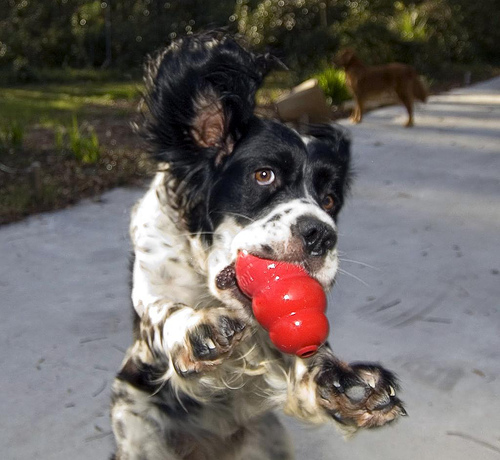

In [ ]:
idx = random.randrange(0, len(val_imgs))
img_path = val_imgs[idx]

pred_caption = generate_caption(img_path)
print('Predicted Caption:', pred_caption)
print()
Image.open(img_path)

Predicted Caption: a white dog is jumping over a hurdle



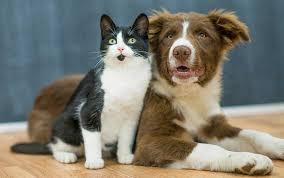

In [ ]:
url = "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcT2j6yclbKYDav4BGUKLAdTvSFXp1gtuzy5DQ&usqp=CAU"
im = Image.open(requests.get(url, stream=True).raw)
im.save('tmp.jpg')

pred_caption = generate_caption('tmp.jpg')
print('Predicted Caption:', pred_caption)
print()
im

In [ ]:
from google.colab import files

# Upload image(s) from local system
uploaded = files.upload()  # opens file picker

# Show uploaded file names
for filename in uploaded.keys():
    print("Uploaded file:", filename)


Saving IMG-20241005-WA0010.jpg to IMG-20241005-WA0010.jpg
Uploaded file: IMG-20241005-WA0010.jpg


Predicted Caption: a woman in a blue shirt is standing on a grassy field


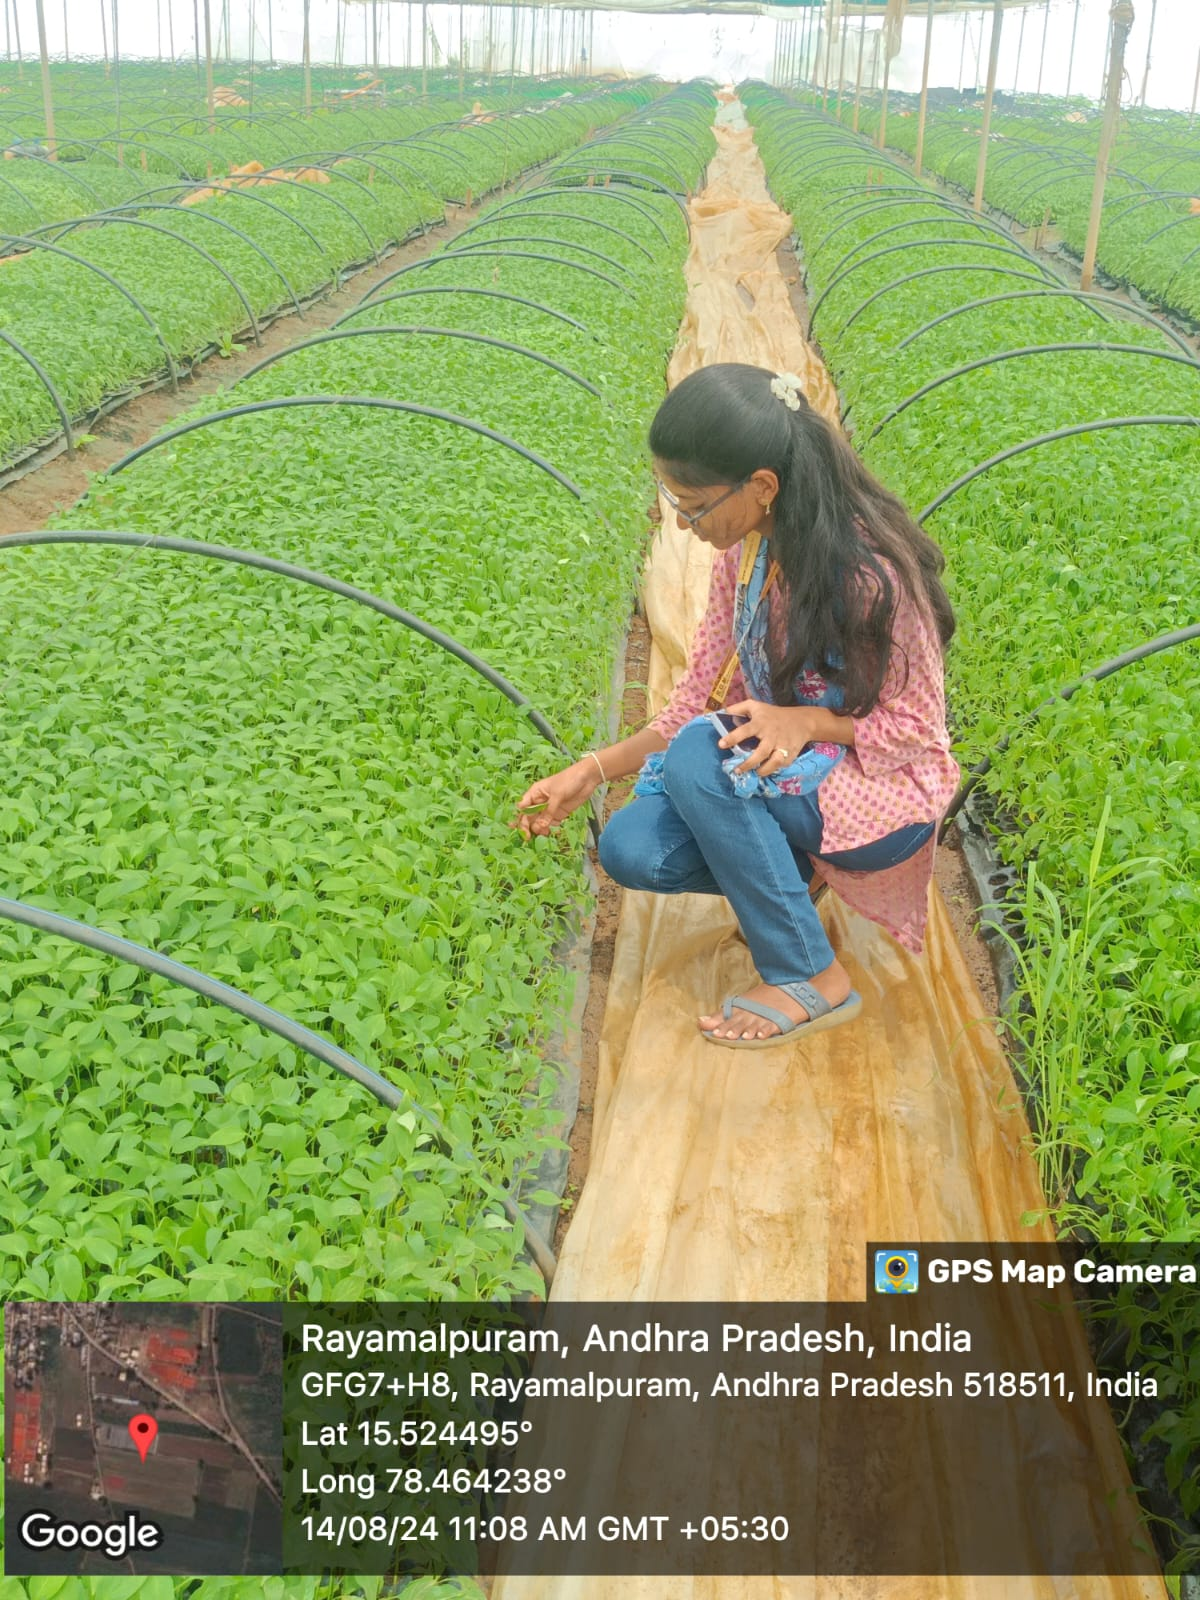

In [ ]:
from PIL import Image

for filename in uploaded.keys():
    img_path = filename
    pred_caption = generate_caption(img_path)
    print("Predicted Caption:", pred_caption)
    display(Image.open(img_path))

In [ ]:
!pip install googletrans==4.0.0-rc1

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.1/55.1 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.0/65.0 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 78.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.6/53.6 kB 5.3 MB/s eta 0:00:00
  Created wheel for googletrans: filename=googletrans-4.0.0rc1-py3-none-any.whl size=17396 sha256=f5bfb6e11cf537a560fcb8c608df2a38d4aa9c34c4c6792f477fc9c428e1cf12
  Stored in directory: /root/.cache/pip/wheels/95/0f/04/b17a72024b56a60e499ce1a6313d283ed5ba332407155bee03
Successfully built googletrans
  Attempting uninstall: hyperframe
    Found existing installation: hyperframe 6.1.0
    Uninstalling hyperfra

In [ ]:
from googletrans import Translator

translator = Translator()

def generate_caption_in_language(img_path, lang='hi'):
    """
    lang: target language code (e.g. 'hi' = Hindi, 'fr' = French, 'te' = Telugu)
    """
    caption_en = generate_caption(img_path)   # English caption from your model
    translated = translator.translate(caption_en, dest=lang)
    return translated.text

# Example
img_path = filename
print("English Caption:", generate_caption(img_path))
print("Hindi Caption:", generate_caption_in_language(img_path, lang='hi'))
print("French Caption:", generate_caption_in_language(img_path, lang='fr'))
print("Telugu Caption:", generate_caption_in_language(img_path, lang='te'))

English Caption: a woman in a blue shirt is standing on a grassy field
Hindi Caption: एक नीली शर्ट में एक महिला एक घास के मैदान पर खड़ी है
French Caption: Une femme dans une chemise bleue se tient sur un champ herbeux
Telugu Caption: నీలిరంగు చొక్కాలో ఉన్న ఒక మహిళ గడ్డి పొలంలో నిలబడి ఉంది


In [ ]:
!pip install rouge

In [ ]:
caption_model.save_weights('image_captioning_transformer.weights.h5')
# if not load_weights:
#      from google.colab import drive
#      drive.mount('/content/drive')

# with open('/content/drive/MyDrive/Saved Models/ImageCaptioning/image_captioning_transformer_weights.h5', 'wb') as f:
#     f.write(open('image_captioning_transformer_weights.h5', 'rb').read())

In [ ]:
#!pip install gradio tensorflow pillow googletrans==4.0.0-rc1

import gradio as gr
from PIL import Image
from googletrans import Translator

def generate_caption(image):
    img = load_image_from_path(img_path)
    img = tf.expand_dims(img, axis=0) # Add batch dimension here
    img_embed = caption_model.cnn_model(img)
    img_encoded = caption_model.encoder(img_embed, training=False)

    y_inp = '[start]'
    for i in range(MAX_LENGTH-1):
        tokenized = tokenizer([y_inp])[:, :-1]
        mask = tf.cast(tokenized != 0, tf.int32)
        pred = caption_model.decoder(
            tokenized, img_encoded, training=False, mask=mask)

        pred_idx = np.argmax(pred[0, i, :])
        pred_word = idx2word(pred_idx).numpy().decode('utf-8')
        if pred_word == '[end]':
            break

        y_inp += ' ' + pred_word

    y_inp = y_inp.replace('[start] ', '')
    return y_inp

# Translation helper
def translate_caption(text, lang):
    translator = Translator()
    return translator.translate(text, dest=lang).text

# Main interface function
def caption_and_translate(image):
    english = generate_caption(image)
    hindi = translate_caption(english, 'hi')
    french = translate_caption(english, 'fr')
    telugu = translate_caption(english, 'te')
    return english, hindi, french, telugu

# Create the Gradio interface
demo = gr.Interface(
    fn=caption_and_translate,
    inputs=gr.Image(type="filepath", label="Upload Image"),
    outputs=[
        gr.Textbox(label="English Caption"),
        gr.Textbox(label="Hindi Translation"),
        gr.Textbox(label="French Translation"),
        gr.Textbox(label="Telugu Translation")
    ],
    title="🖼️ Image Caption Generator",
    description="Upload an image to generate and translate its caption."
)

demo.launch()


Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
IMPORTANT: You are using gradio version 4.19.1, however version 4.44.1 is available, please upgrade.
--------
Running on public URL: https://7084d4b7eeafbb9752.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)
